In [1]:
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import ascii
from scipy.interpolate import interp1d
import cv2 as cv
from astropy import wcs
from astropy.cosmology import LambdaCDM as Cos
from scipy.stats import kde
import fitsio

In [2]:
redmapper_T = Table.read("Data/redmapper_dr8_public_v6.3_catalog.fits.gz")

In [3]:
redmapper = redmapper_T["ID","NAME","RA","DEC","Z_LAMBDA","Z_LAMBDA_ERR","LAMBDA","LAMBDA_ERR","S","Z_SPEC","OBJID","IMAG","IMAG_ERR"].to_pandas()

In [4]:
data = ascii.read("Data/clusters.dat").to_pandas()

In [5]:
columns = ["ID",
    "RA",
    "DEC",
    "zphot",
    "zspec",
    "den",
    "Bkg",
    "RAMdeg",
    "DEMdeg",
    "Ng",
    "Ltot",
    "M500",
    "R500",
    "Richness",
    "RABdeg",
    "DEBdeg",
    "zphotB",
    "e_zphotB",
    "zspecB",
    "gmag",
    "rmag",
    "zmag",
    "W1mag",
    "W2mag",
    "e_gmag",
    "e_rmag",
    "e_zmag",
    "e_W1mag",
    "e_W2mag",
    "gMag",
    "rMag",
    "zMag",
    "W1Mag",
    "W2Mag",
    "Mass",
    "b_Mass",
    "B_Mass"]
data.columns = columns

In [6]:
data["edge_mask"] = np.load("zou_mask.npy")

In [7]:
zou = data[data.edge_mask == 1]

In [8]:
clumpr = Table.read("DESI_clusters_final_2023_full.fits").to_pandas()

In [9]:
clumpr_mask = np.load("clumpr_mask.npy")

In [10]:
x_scale, y_scale = (0.016003200640128026, 0.03280656131226245)
dim_x = 0.285/x_scale
dim_y = 0.285/y_scale

In [11]:
ra_min = -3
redmapper["ra_indices"] = np.round(((redmapper.RA-298)%360*np.cos(np.pi/180*redmapper.DEC) - ra_min)/y_scale)
#data["dec_indices"] = np.round((data.DEC_central - data.DEC_central.min())/x_scale)
redmapper["dec_indices"] = np.round((redmapper.DEC - -70)/x_scale)

In [12]:
redmapper["edge_mask"] = clumpr_mask[redmapper.dec_indices.astype("int").to_list(), redmapper.ra_indices.astype("int").to_list()]

In [13]:
data2 = redmapper[redmapper.edge_mask == 0]

In [14]:
H_uneq2, xedges, yedges = np.histogram2d(data2.DEC, (data2.RA-298)%360, bins = (np.linspace(np.min(data2.DEC), np.max(data2.DEC), 1000), np.linspace(np.min((data2.RA-298)%360), np.max((data2.RA-298)%360), 1000)))

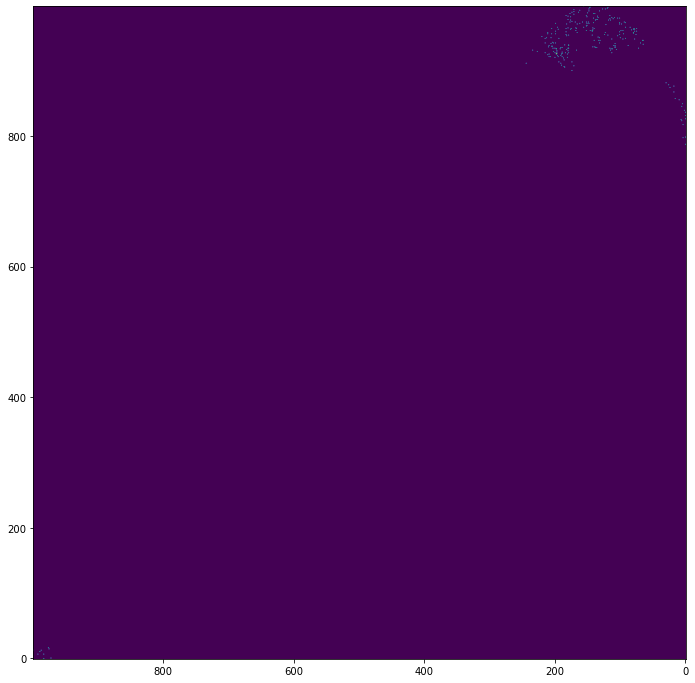

In [15]:
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq2, vmax = 1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

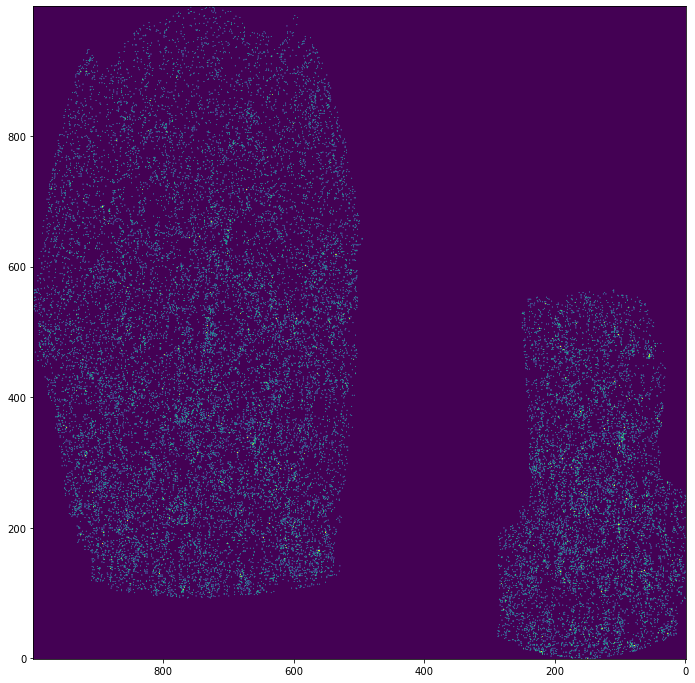

In [16]:
data2 = redmapper[redmapper.edge_mask == 1]
H_uneq2, xedges, yedges = np.histogram2d(data2.DEC, (data2.RA-298)%360, bins = (np.linspace(np.min(data2.DEC), np.max(data2.DEC), 1000), np.linspace(np.min((data2.RA-298)%360), np.max((data2.RA-298)%360), 1000)))
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq2, vmax = 1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

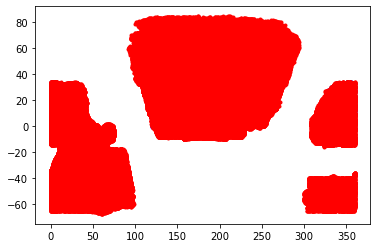

In [17]:
plt.plot(data2.RA, data2.DEC, ".b")
plt.plot(clumpr.RA_central, clumpr.DEC_central, ".r")

In [18]:
catalog = SkyCoord(ra=clumpr.RA_central.to_numpy()*u.degree, dec=clumpr.DEC_central.to_numpy()*u.degree)
c = SkyCoord(ra=data2.RA.to_numpy()*u.degree, dec=data2.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [19]:
len(c_matches[data2[sep_constraint].Z_LAMBDA > 0.1])/len(data2[data2.Z_LAMBDA > 0.1])

0.9501614597517799

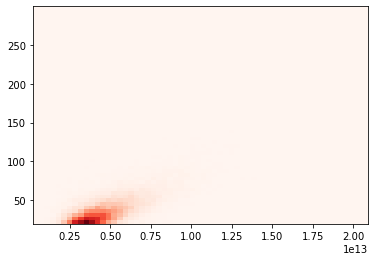

In [20]:
counts,ybins,xbins,image = plt.hist2d(10**clumpr.iloc[idx[sep_constraint]].cluster_mass_onempc, data2[sep_constraint].LAMBDA, bins=60, cmap = "Reds")
data_kde = np.array([data2[sep_constraint].LAMBDA, 10**clumpr.iloc[idx[sep_constraint]].cluster_mass_onempc])
k = kde.gaussian_kde(data_kde)
nbins = 100
xi, yi = np.mgrid[xbins.min():xbins.max():nbins*1j, ybins.min():ybins.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [21]:
np.min(data2[sep_constraint].LAMBDA)

19.850935

In [23]:
np.min(data2.LAMBDA)

19.850935

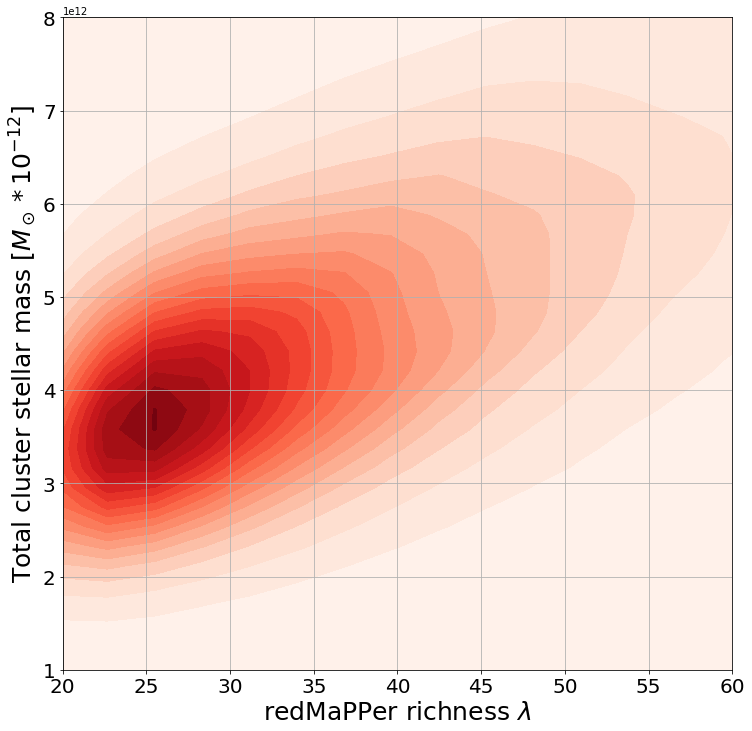

In [22]:
plt.figure(figsize = (12, 12))
plt.ylabel("Total cluster stellar mass [$M_\odot * 10^{-12}$]", fontsize = 25)
plt.xlabel("redMaPPer richness $\lambda$", fontsize = 25)
#plt.title("Figure 2: Stellar mass distribution of CluMPR galaxy clusters", fontsize = 25)
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Reds")
#plt.colorbar(label = "Number density of clusters")
#plt.contour(xi, yi, zi.reshape(xi.shape), cmap = "gray")
plt.contourf(xi, yi, zi.reshape(xi.shape), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],cmap = "Reds", levels = 20)

#plt.colorbar(label = "Number density of clusters")
plt.xlim(20, 60)
plt.ylim(1e12, 0.8e13)
plt.grid()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("mass_redmapper.pdf", dpi = 300)
plt.show()

(0.0, 11000000000000.0)

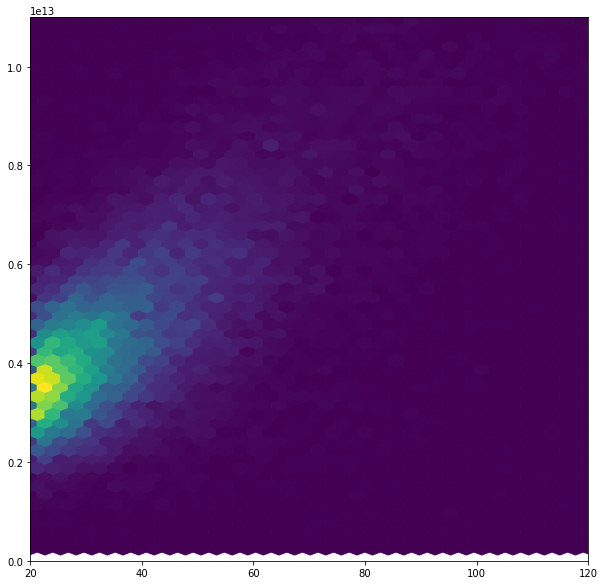

In [58]:
plt.figure(figsize = (10, 10))
plt.hexbin(data2[sep_constraint].LAMBDA, 10**clumpr.iloc[idx[sep_constraint]].cluster_mass_onempc)
plt.xlim(20, 120)
plt.ylim(0, 1.1e13)

In [45]:
catalog = SkyCoord(ra=zou.RA.to_numpy()*u.degree, dec=zou.DEC.to_numpy()*u.degree)
c = SkyCoord(ra=data2.RA.to_numpy()*u.degree, dec=data2.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [46]:
len(c_matches)/len(data2)

0.9896413110698825

In [47]:
len(c_matches[data2[sep_constraint].Z_LAMBDA > 0.1])/len(data2[data2.Z_LAMBDA > 0.1])

0.9900400731432129

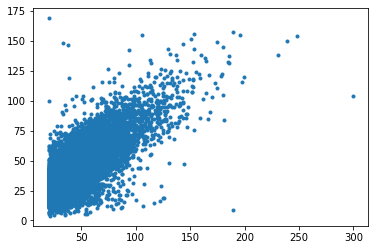

In [49]:
plt.plot(data2[sep_constraint].LAMBDA, zou.iloc[idx[sep_constraint]].Richness, ".")

In [10]:
fits_data = fitsio.FITS("/global/cfs/cdirs/cosmo/data/sdss/dr17/sdss/spectro/redux/specObj-dr17.fits")

In [11]:
redshifts = fits_data[1].read(columns=['CLASS', 'SUBCLASS', 'PLUG_RA', 'PLUG_DEC', 'Z', 'Z_ERR'])

In [12]:
zs = pd.DataFrame(redshifts.byteswap().newbyteorder(), columns = ['CLASS', 'SUBCLASS', 'PLUG_RA', 'PLUG_DEC', 'Z', 'Z_ERR'])

In [14]:
spec_z = zs[np.logical_and.reduce((zs.CLASS == "GALAXY", zs.Z_ERR < 1e-3, zs.Z > 0))]

In [15]:
len(spec_z)

3161805

In [16]:
c = SkyCoord(ra=clumpr.RA_central.to_numpy()*u.degree, dec=clumpr.DEC_central.to_numpy()*u.degree)
catalog = SkyCoord(ra=spec_z.PLUG_RA.to_numpy()*u.degree, dec=spec_z.PLUG_DEC.to_numpy()*u.degree)

max_sep = 5 * u.arcsec
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [17]:
len(c_matches)/len(clumpr)

0.2628632788176839

In [18]:
clumpr["spec_z"] = -1*np.ones(len(clumpr))
clumpr["spec_z_err"] = -1*np.ones(len(clumpr))

In [19]:
clumpr.loc[sep_constraint, "spec_z"] = spec_z.iloc[idx[sep_constraint]].Z.values
clumpr.loc[sep_constraint, "spec_z_err"] = spec_z.iloc[idx[sep_constraint]].Z_ERR.values

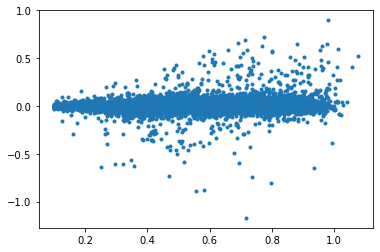

In [21]:
clumpr_test = clumpr[clumpr.spec_z > -1].copy()
plt.plot(clumpr_test.z_median_central, clumpr_test.z_median_central - clumpr_test.spec_z, ".")

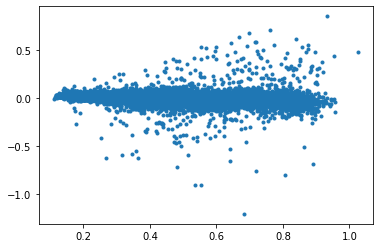

In [22]:
clumpr_test = clumpr[clumpr.spec_z > -1].copy()
plt.plot(clumpr_test.z_average_mass_prob, clumpr_test.z_average_mass_prob - clumpr_test.spec_z, ".")

In [23]:
saving = clumpr.copy().to_records(index = False)

In [24]:
fits.writeto("DESI_clusters_final_2023_full_speczs.fits", saving)